In [1]:
import pandas as pd
import numpy as np
import tensorflow 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import datetime
import re
import string

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train = train.fillna("")
train['new_text'] = train['keyword'] + " " + train['location'] + " " + train['text']

test = test.fillna("")
test['new_text'] = test['keyword'] + " " + test['location'] + " " + test['text']

In [6]:
print("Size of train dataset: " + str(train.shape))
print("Size of test dataset: " + str(test.shape))

Size of train dataset: (7613, 6)
Size of test dataset: (3263, 5)


### Use GPU if its available

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
    print("There are %d GPU(s) available" % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU Available, using CPU instead")

There are 1 GPU(s) available
We will use the GPU: NVIDIA GeForce RTX 3070 Ti


### Loop to remove noise from tweets

In [8]:
def remove_noise(df):
    df = df.copy()
    new_tweets = []
    for text in df['new_text']:
        # it will remove the old style retweet text "RT"
        new_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

        # it will remove hyperlinks
        new_text = re.sub(r'https?:\/\/.*[\r\n]*', '', new_text)

        # it will remove hashtags. We have to be careful here not to remove 
        # the whole hashtag because text of hashtags contains huge information. 
        # only removing the hash # sign from the word
        # tweet2 = re.sub(r'#', '', tweet2)
        new_text = ''.join([c for c in new_text if ord(c) < 128])

        # it will remove single numeric terms in the tweet. 
#         new_text = re.sub(r'[0-9]', '', new_text) # does temporal information matter to bert? lets test it out
#         print('\nAfter removing old style tweet, hyperlinks and # sign')
        new_tweets.append(new_text)
    
    df['new_text'] = new_tweets
    return df

In [9]:
new_train = train.copy()
new_train = remove_noise(new_train)

In [10]:
new_train[new_train['id'] == 404]['new_text'].values[0]

"apocalypse Elk Grove, CA, USA Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014!  #internetradio #collegeradi_"

In [11]:
train[train['id'] == 404]['new_text'].values[0]

"apocalypse Elk Grove, CA, USA Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014! http://t.co/cf9e6TU3g7 #internetradio #collegeradi\x89Û_"

In [12]:
# tweet = train[train['id'] == 219]['text'].values[0]
# tweet

In [13]:
# # it will remove the old style retweet text "RT"
# tweet2 = re.sub(r'^RT[\s]+', '', tweet)

# # it will remove hyperlinks
# tweet2 = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet2)

# # it will remove hashtags. We have to be careful here not to remove 
# # the whole hashtag because text of hashtags contains huge information. 
# # only removing the hash # sign from the word
# # tweet2 = re.sub(r'#', '', tweet2)
# tweet2 = ''.join([c for c in tweet2 if ord(c) < 128])

# # it will remove single numeric terms in the tweet. 
# tweet2 = re.sub(r'[0-9]', '', tweet2) # does temporal information matter to bert? lets test it out
# print('\nAfter removing old style tweet, hyperlinks and # sign')
# tweet2

### Initialize tokenizer and finding the average length of tokens for train and test sets

In [14]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [15]:
train_inputs = []
test_inputs = []
train_length = []
test_length = []

# for sentence in train['text']:
for sentence in new_train['new_text']:
    encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
    train_inputs.append(encoded_sentence)
    train_length.append(len(encoded_sentence))

for sentence in test['new_text']:
    encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
    test_inputs.append(encoded_sentence)
    test_length.append(len(encoded_sentence))

print("Train")
print("Min Length:", min(train_length))
print("Median Length:", np.median(train_length))
print("Max Length:", max(train_length))
print("")

print("Test")
print("Min Length:", min(test_length))
print("Median Length:", np.median(test_length))
print("Max Length:", max(test_length))

Train
Min Length: 4
Median Length: 28.0
Max Length: 93

Test
Min Length: 4
Median Length: 38.0
Max Length: 82


C:\Users\Doubl\Desktop\Projects\nlp\disaster_tweets\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

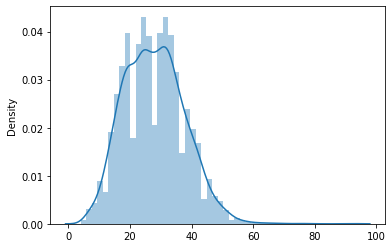

In [16]:
sns.distplot(train_length)

C:\Users\Doubl\Desktop\Projects\nlp\disaster_tweets\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

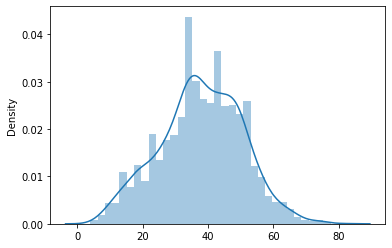

In [17]:
sns.distplot(test_length)

In [18]:
MAX_LEN = 90

### Distribution of disaster to non-disaster tweets

In [19]:
labels = new_train['target']
print("Number of disaster tweets: " + str(len(train[train['target'] == 1]['target'])))
print("Number of non-disaster tweets: " + str(len(train[train['target'] == 0]['target'])))
print("Percentage of disaster to non-disaster tweets: " + str(round(len(train[train['target'] == 1]['target']) / len(train['target']), 2)))

Number of disaster tweets: 3271
Number of non-disaster tweets: 4342
Percentage of disaster to non-disaster tweets: 0.43


In [20]:
X = new_train.drop(columns = ['target'])
y = new_train['target']
SEED = 2022

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = SEED)

In [21]:
print("Shape of training data:", str(X_train.shape))
print("Shape of validation data:", str(X_val.shape))

Shape of training data: (6090, 5)
Shape of validation data: (1523, 5)


### Preprocess the data into input_ids and attention masks 

In [22]:
from keras.preprocessing.sequence import pad_sequences

def process_data(df, max_length):
    input_ids = []
    attention_masks = []
    
    for sentence in df['new_text']:
        encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
        input_ids.append(encoded_sentence)
        
    input_ids = pad_sequences(input_ids, maxlen = max_length, dtype = 'long', value = 0, 
                             truncating = 'post', padding = 'post')
    
    for sentence in input_ids:
        attention_masks.append([1 if id > 0 else 0 for id in sentence])
                                
    return input_ids, np.array(attention_masks, dtype = np.int64)

In [23]:
train_inputs, train_attn_masks = process_data(X_train, MAX_LEN)
val_inputs, val_attn_masks = process_data(X_val, MAX_LEN)
test_inputs, test_attn_masks = process_data(test, MAX_LEN)

In [24]:
print("Train input size: ", str(train_inputs.shape))
print("Validation input size: ", str(val_inputs.shape))
print("Test input size: ", str(test_inputs.shape))

Train input size:  (6090, 90)
Validation input size:  (1523, 90)
Test input size:  (3263, 90)


### Convert to numpy int64, then into pytorch tensors

In [25]:
train_inputs = train_inputs.astype(np.int64)
val_inputs = val_inputs.astype(np.int64)
test_inputs = test_inputs.astype(np.int64)

train_labels = np.array(y_train, dtype = np.int64)
val_labels = np.array(y_val, dtype = np.int64)

In [26]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attn_masks)

val_inputs = torch.tensor(val_inputs)
val_labels = torch.tensor(val_labels)
val_masks = torch.tensor(val_attn_masks)

test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_attn_masks)

### Batch the data into DataLoaders

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

### Initializing the model, optimizer and scheduler

In [28]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [29]:
model.cuda()
model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

In [30]:
from transformers import get_linear_schedule_with_warmup

epochs = 15
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0, # default value in run glue.py
    num_training_steps = total_steps
)

### Training Loop

In [31]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [33]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

train_acc = []
val_acc = []
train_losses=[]

for epoch in range(0, epochs):
    print("Epoch {:} / {:}".format(epoch, epochs))
    print("Training...")
    
    t0 = time.time()
    total_loss = 0
    train_accuracy, nb_train_steps = 0, 0
    
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}".format(step, len(train_dataloader), elapsed))
            
        batch = tuple(t.to(device) for t in batch)
        batch_input_ids, batch_input_masks, batch_labels = batch

        model.zero_grad()

        outputs = model(batch_input_ids, token_type_ids = None, attention_mask = batch_input_masks,
                       labels = batch_labels)

        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs['logits']

        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        
        nb_train_steps += 1

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    average_train_loss = total_loss / len(train_dataloader)
    train_losses.append(average_train_loss)
    train_accuracy = train_accuracy / nb_train_steps
    train_acc.append(train_accuracy)
    
    print("")
    print("Training Accuracy: {0:.5f}".format(train_accuracy))
    print("Average training loss: {0:.5f}".format(average_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    print("")
    print("Running Validation")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        batch_input_ids, batch_input_masks, batch_labels = batch
        
        with torch.no_grad():
            outputs = model(batch_input_ids, token_type_ids = None, 
                            attention_mask = batch_input_masks)
        
        logits = outputs['logits']
#         print(logits)
#         print(logits.shape)
        
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_steps += 1
    
    val_accuracy = eval_accuracy / nb_eval_steps
    val_acc.append(val_accuracy)
    
    print("")
    print("Accuracy: {0:.5f}".format(val_accuracy))
    print("Validation took: {:}".format(format_time(time.time() - t0)))
    print("")

print("Training Complete")

Epoch 0 / 15
Training...
Batch   100 of   381. Elapsed: 0:00:13
Batch   200 of   381. Elapsed: 0:00:24
Batch   300 of   381. Elapsed: 0:00:35

Training Accuracy: 0.79075
Average training loss: 0.45775
Training epoch took: 0:00:44

Running Validation

Accuracy: 0.83572
Validation took: 0:00:03

Epoch 1 / 15
Training...
Batch   100 of   381. Elapsed: 0:00:11
Batch   200 of   381. Elapsed: 0:00:23
Batch   300 of   381. Elapsed: 0:00:34

Training Accuracy: 0.87589
Average training loss: 0.32530
Training epoch took: 0:00:43

Running Validation

Accuracy: 0.84679
Validation took: 0:00:03

Epoch 2 / 15
Training...
Batch   100 of   381. Elapsed: 0:00:11
Batch   200 of   381. Elapsed: 0:00:22
Batch   300 of   381. Elapsed: 0:00:33

Training Accuracy: 0.92100
Average training loss: 0.23399
Training epoch took: 0:00:42

Running Validation

Accuracy: 0.83485
Validation took: 0:00:03

Epoch 3 / 15
Training...
Batch   100 of   381. Elapsed: 0:00:11
Batch   200 of   381. Elapsed: 0:00:23
Batch   300 

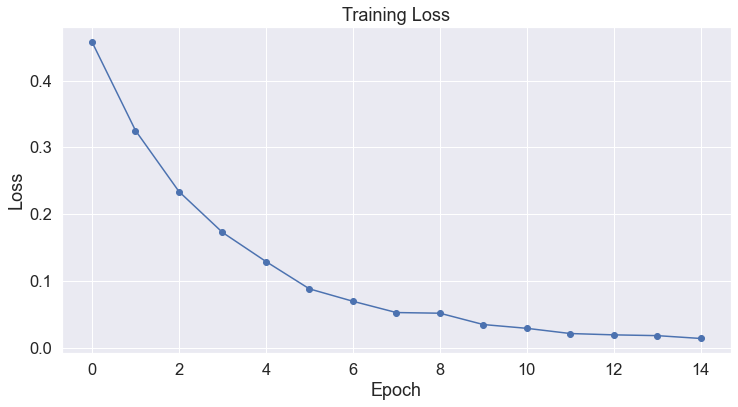

In [34]:
sns.set(style='darkgrid')
sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(train_losses, 'b-o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [35]:
r_dict = {
    "train_accuracy": train_acc,
    "train_loss": train_losses,
    "val_accuracy": val_acc
}

In [36]:
results = pd.DataFrame(r_dict)
results

,train_accuracy,train_loss,val_accuracy
0,0.790748,0.457754,0.835720
1,0.875886,0.325304,0.846788
2,0.920997,0.233993,0.834852
3,0.944554,0.172894,0.840495
4,0.960302,0.129348,0.794922
5,0.972933,0.088399,0.817925
6,0.979167,0.069872,0.817925
7,0.984416,0.052981,0.822049
8,0.985236,0.052007,0.807943
9,0.988025,0.035039,0.830512


In [37]:
# test_data = TensorDataset(test_inputs, test_masks)
# test_sampler = SequentialSampler(test_data)
# test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

# print("Predicting labels for {:,} test sentences...".format(len(test_inputs)))

# model.eval() # SET THE MODEL TO EVALUATION MODE

# predictions, true_labels = [], []

# t0 = time.time()

# for (step, batch) in enumerate(test_dataloader):
#     batch = tuple(t.to(device) for t in batch)
    
#     # Progress update every 100 batches
#     if step % 100 == 0 and not step == 0:
#         elapse = format_time(time.time() - t0)
#         print("Batch {:>5,} of {:>5,}. Elapse {:}.".format(step, len(test_dataloader), elapsed))
    
#     # unpack the inputs from our dataloader
#     b_input_ids, b_input_mask = batch
    
#     # Telling the model not to compute or store gradients, saving memeory and speeding up prediction
#     with torch.no_grad():
#         outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
    
#     logits = outputs[0]
    
#     # Move logits and labels to CPU
#     logits = logits.detach().cpu().numpy()
# #     label_ids = b_labels.to('cpu').numpy()
    
#     # Store predictions and true labels
#     predictions.append(logits)
# #     true_labels.append(label_ids)

# print("Done")

In [38]:
# predictions = np.concatenate(predictions, axis = 0)
# predictions[:10]

In [39]:
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# batch_size = 32

# train_data = TensorDataset(input_ids, attention_masks, labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# test_data = 